In this notebook we analyze the performance of our fine-tuned DistilBERT classifier.

# Load the Dataset

In [1]:
from datasets import load_dataset

In [2]:
emotion = load_dataset('emotion')
labels = emotion['train'].features['label'].names
label_name = {
    f"LABEL_{i}": labels[i] for i in range(len(labels))
}
label_index = {
    f"LABEL_{i}": i for i in range(len(labels))
}

# Load the Fine-Tuned Model

In [3]:
import os
from transformers import AutoTokenizer, pipeline

In [4]:
model_name = "distilbert-base-uncased-finetuned-emotion"
model_dir = os.path.join("../models", model_name)
model_on_hub = "florianehmann/" + model_name

if os.path.exists(model_dir):
    classifier = pipeline("text-classification", model=model_dir)
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
else:
    classifier = pipeline("text-classification", model=model_on_hub)
    tokenizer = AutoTokenizer.from_pretrained(model_on_hub)

In [5]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [6]:
emotion_tokenized = emotion.map(tokenize, batched=True, batch_size=None)

# Analyze the Results

## Determine a Confusion Matrix

In [7]:
import pandas as pd

In [8]:
emotion.reset_format()

pred = classifier.predict(emotion['validation']['text'])

In [9]:
emotion.set_format('pandas')

pred_df = pd.DataFrame(pred)
pred_df['predicted_label'] = pred_df['label'].apply(lambda l: label_index[l])
pred_df['predicted_label_name'] = pred_df['label'].apply(lambda l: label_name[l])
pred_df['true_label'] = emotion['validation'][:]['label']
pred_df['true_label_name'] = emotion['validation'][:]['label'].apply(lambda i: labels[i])

In [10]:
pred_df.head()

,label,score,predicted_label,predicted_label_name,true_label,true_label_name
0,LABEL_0,0.989753,0,sadness,0,sadness
1,LABEL_0,0.990213,0,sadness,0,sadness
2,LABEL_2,0.618537,2,love,2,love
3,LABEL_3,0.984676,3,anger,3,anger
4,LABEL_1,0.992215,1,joy,1,joy


In [11]:
y_true = pred_df['true_label']
y_pred = pred_df['predicted_label']

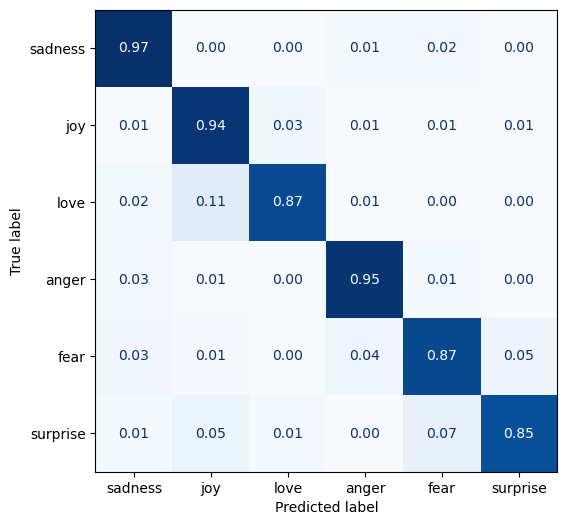

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(6,6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)

plt.show()

The diagonal entries show that the model does pretty well on all emotions, but there are some situations in which is does worse than others. For example, the largest off-diagonal entry is 0.11 in the *love* row. This shows that 11% of the *love*-classified tweets are misclassified as *joy*. That is something we can look into in the next step.

We can also see that the diagonal entry for *surprise* is the lowest out of all classes. That comes as no surprise, as surpise usually comes bundeled with a different emotion that both our model and the training data labelers can pick up on.

## Look into Love-Joy Misclassification

In [13]:
import textwrap

In [14]:
misclassification_df = pred_df[(pred_df.true_label_name == 'love') &
                               (pred_df.predicted_label_name == 'joy')]
misclassification_df.insert(0, 'text', value=emotion['validation'][:]
                                       .loc[misclassification_df.index]['text'])

In [15]:
for text in misclassification_df.sample(5)['text'].values:
    wrapped_text = textwrap.fill(text, width=80, initial_indent='> ', subsequent_indent='  ')
    print(wrapped_text, end='\n\n\n')

> i feel my sweet boy traveling this difficult road alongside me


> i can say is that i feel like myself when i put on a skirt heels and lipstick
  and when i wear clothing which has come to be accepted as neutral and
  nondescript like a t shirt and jeans i dont feel like myself


> i feel god calling me there and if he wills it i ll be a priest for him and
  the rest of the faithful


> i know have no problem meeting new people and feeling accepted


> i have had several new members tell me how comfortable they feel with how
  accepted they are by the existing members and that is great to hear




From these seemingly misclassified samples, we can conclude that even if the line between joy and love can be blurry sometimes, some on the samples in the validation set suffer from this problem too, as some of these tweets are clearly mislabeled.

For us, that means that our model did not do as badly as we thought at first, but it also means that we likely have some mislabeld data in the training set as well, keeping our model from reaching its full potential.